In [ ]:
#!pip install xgboost

In [1]:
#imports
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
import os
import sys
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
path = 'XGBoost_model'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', path)
print(os.listdir(GOOGLE_DRIVE_PATH))

sys.path.append(GOOGLE_DRIVE_PATH)

['newborn_health_monitoring_with_risk.csv', 'clean_newborn_monitoring.csv', 'final_best_model.pkl', 'XGBoost.ipynb']


In [4]:
df = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, "clean_newborn_monitoring.csv"))
df

,Unnamed: 0,baby_id,name,gender,gestational_age_weeks,birth_weight_kg,birth_length_cm,birth_head_circumference_cm,date,age_days,...,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal,risk_level,feeding_type_Breastfeeding,feeding_type_Formula,feeding_type_Mixed
0,0,B001,Sara,0,40.2,3.30,50.0,31.9,2024-12-10,1,...,9,0,4.2,7.0,1,1,1,0,1,0
1,1,B001,Sara,0,40.2,3.30,50.0,31.9,2024-12-11,2,...,5,2,10.6,7.0,0,0,1,0,1,0
2,2,B001,Sara,0,40.2,3.30,50.0,31.9,2024-12-12,3,...,6,5,9.8,7.0,0,0,0,1,0,0
3,3,B001,Sara,0,40.2,3.30,50.0,31.9,2024-12-13,4,...,8,4,8.1,7.0,0,1,0,0,0,1
4,4,B001,Sara,0,40.2,3.30,50.0,31.9,2024-12-14,5,...,7,1,11.6,7.0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,B100,Brian,1,39.1,4.47,50.8,36.3,2025-03-31,26,...,7,4,4.0,10.0,0,1,0,0,1,0
2996,2996,B100,Brian,1,39.1,4.47,50.8,36.3,2025-04-01,27,...,6,1,2.4,10.0,0,1,0,1,0,0
2997,2997,B100,Brian,1,39.1,4.47,50.8,36.3,2025-04-02,28,...,4,1,3.6,10.0,0,1,0,1,0,0
2998,2998,B100,Brian,1,39.1,4.47,50.8,36.3,2025-04-03,29,...,5,2,2.2,10.0,0,0,0,0,0,1


In [5]:
#Find correlation of all columns with risk_level
corr = df.corr(numeric_only=True)['risk_level'].sort_values(ascending=False)
print(corr)

risk_level                     1.000000
jaundice_level_mg_dl           0.630719
heart_rate_bpm                 0.140606
temperature_c                  0.039322
feeding_frequency_per_day      0.031606
birth_length_cm                0.020414
respiratory_rate_bpm           0.011266
birth_head_circumference_cm    0.010155
gender                         0.010074
urine_output_count             0.009211
feeding_type_Mixed             0.008900
apgar_score                    0.003226
feeding_type_Formula           0.001249
reflexes_normal               -0.002023
Unnamed: 0                    -0.006619
feeding_type_Breastfeeding    -0.010110
stool_count                   -0.015292
gestational_age_weeks         -0.026819
head_circumference_cm         -0.028080
birth_weight_kg               -0.031241
length_cm                     -0.047907
immunizations_done            -0.069071
oxygen_saturation             -0.154930
weight_kg                     -0.171307
age_days                      -0.338664


<Axes: xlabel='age_days', ylabel='jaundice_level_mg_dl'>

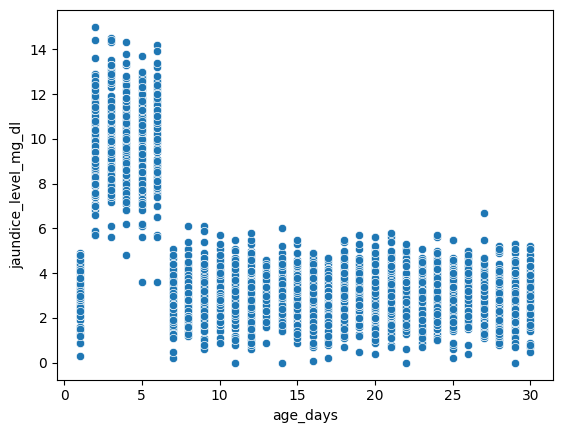

In [6]:
df[['jaundice_level_mg_dl', 'age_days']].corr()
sns.scatterplot(x='age_days', y='jaundice_level_mg_dl', data=df)

In [7]:
y = df['risk_level']
columns_to_drop = ['Unnamed: 0', 'baby_id', 'name', 'date', 'risk_level', 'jaundice_level_mg_dl', 'apgar_score', 'birth_weight_kg', 'birth_length_cm', 'birth_head_circumference_cm']
X = df.drop(columns=columns_to_drop)

# print("Shape of X:", X.shape)
# print("Shape of y:", y.shape)

In [8]:
X.shape

(3000, 18)

##Experiment 1: Split into training and testing and fine tune model



In [9]:
# Split data into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split temporary set into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#balance classes using smote
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [10]:
#Vanilla XGBoost Classifier with smote

model = XGBClassifier()
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_val)

f1 = f1_score(y_val, y_pred, average='macro')

f1

0.8293227696068102

In [11]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       391
           1       0.68      0.73      0.70        59

    accuracy                           0.92       450
   macro avg       0.82      0.84      0.83       450
weighted avg       0.92      0.92      0.92       450



In [ ]:
#Vanilla XGBoost Classifier with scale_pos_weight

weight_value = np.sum(y_train == 0) / np.sum(y_train == 1)

model = XGBClassifier(scale_pos_weight = weight_value)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

f1 = f1_score(y_val, y_pred, average='macro')

f1

0.8374193548387097

In [ ]:
#On Validation set (with scale pos weight)
cm = confusion_matrix(y_val, y_pred)
print(cm)

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

print("Precision:", precision)
print("Recall:", recall)

tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)

fpr = fp / (fp + tn)

print("TPR: ", tpr)

print("FPR: ", fpr)

print("TPR/FPR: ", tpr/fpr)

[[370  21]
 [ 14  45]]
Precision: 0.6818181818181818
Recall: 0.7627118644067796
TPR:  0.7627118644067796
FPR:  0.05370843989769821
TPR/FPR:  14.20096852300242


In [ ]:
#On test set
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("F1 score:", f1)

print("Confusion Matrix:\n", cm)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

F1 score: 0.4739756367663344
Confusion Matrix:
 [[330  60]
 [ 54   6]]
Precision: 0.09090909090909091
Recall: 0.1


In [ ]:
#Fine-tuning XGBoost Model

param_grid = {
    'max_depth': [3, 5, 8],
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1]
}

grid_search = GridSearchCV(XGBClassifier(), param_grid, scoring='recall') #Have recall since we want to prioritize correctly identifying all actual positives

grid_search.fit(X_train_smote, y_train_smote)

print("Best params:", grid_search.best_params_)

Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')

print("F1 score:", f1)

print("Confusion Matrix:\n", cm)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

F1 score: 0.48045905707196035
Confusion Matrix:
 [[353  37]
 [  0  60]]
Precision: 0.6185567010309279
Recall: 1.0


##Experiment 2, k-fold on training with param grid, use best model to train on entire and test on a held-out test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

weight_value = np.sum(y_train == 0) / np.sum(y_train == 1)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(eval_metric = 'logloss', use_label_encoder=False,
        tree_method='hist',      # REQUIRED for stable parameter usage
        random_state=42))
])

param_grid = {
    'model__max_depth': [3, 5],
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1]
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kfold,
    scoring='recall',
    n_jobs=-1
    )

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)

Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:35:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
recall_scores = []
precision_scores = []
f1_scores = []

# Extract and clean best parameters for XGBoost
best_xgb_params = {k.replace('model__', ''): v for k, v in grid.best_params_.items()}

# Pipeline for best model
best_model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        tree_method="hist",
        random_state=42,
        **best_xgb_params
    ))
])

for train_idx, val_idx in kfold.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    best_model.fit(X_tr, y_tr)

    y_pred = best_model.predict(X_val)

    recall_scores.append(recall_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))

# Printing metrics
print("\n===== FINAL CROSS-VALIDATION METRICS (BEST MODEL) =====")

print("\nRecall scores per fold:", recall_scores)
print("Average Recall:", np.mean(recall_scores))

print("\nPrecision scores per fold:", precision_scores)
print("Average Precision:", np.mean(precision_scores))

print("\nF1 scores per fold:", f1_scores)
print("Average F1:", np.mean(f1_scores))

print("========================================================\n")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:35:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:35:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:35:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:35:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:35:50] WARNING: /w


===== FINAL CROSS-VALIDATION METRICS (BEST MODEL) =====

Recall scores per fold: [0.9818181818181818, 0.9642857142857143, 0.9642857142857143, 1.0, 0.9642857142857143]
Average Recall: 0.974935064935065

Precision scores per fold: [0.6206896551724138, 0.6067415730337079, 0.6136363636363636, 0.6436781609195402, 0.7105263157894737]
Average Precision: 0.6390544137102999

F1 scores per fold: [0.7605633802816901, 0.7448275862068966, 0.75, 0.7832167832167832, 0.8181818181818182]
Average F1: 0.7713579135774377



In [ ]:
# 1. Remove the "model__" prefix
clean_params = {k.replace("model__", ""): v for k, v in grid.best_params_.items()}

# 2. Remove deprecated or non-XGBClassifier parameters like "use_label_encoder"
clean_params.pop("use_label_encoder", None)

# 3. Add required stable XGBoost params manually
clean_params.update({
    "eval_metric": "logloss",
    "tree_method": "hist",
    "random_state": 42
})

# Build pipeline
best_model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(**clean_params))
])

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Recall: 0.9831932773109243
Precision: 0.6256684491978609
F1 Score: 0.7647058823529411

Confusion Matrix:
 [[711  70]
 [  2 117]]


In [ ]:
# 1. Remove the "model__" prefix
clean_params = {k.replace("model__", ""): v for k, v in grid.best_params_.items()}

# 2. Remove deprecated or non-XGBClassifier parameters like "use_label_encoder"
clean_params.pop("use_label_encoder", None)

# 3. Add required stable XGBoost params manually
clean_params.update({
    "eval_metric": "logloss",
    "tree_method": "hist",
    "random_state": 42
})

# Build pipeline
best_model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(**clean_params))
])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Recall: 0.9831932773109243
Precision: 0.6256684491978609
F1 Score: 0.7647058823529411

Confusion Matrix:
 [[711  70]
 [  2 117]]


In [ ]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
ratio = tpr/fpr

print("TPR:", tpr)
print("FPR:", fpr)
print("TPR/FPR Ratio:", ratio)

TPR: 0.9831932773109243
FPR: 0.08962868117797695
TPR/FPR Ratio: 10.969627851140455


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       781
           1       0.63      0.98      0.76       119

    accuracy                           0.92       900
   macro avg       0.81      0.95      0.86       900
weighted avg       0.95      0.92      0.93       900



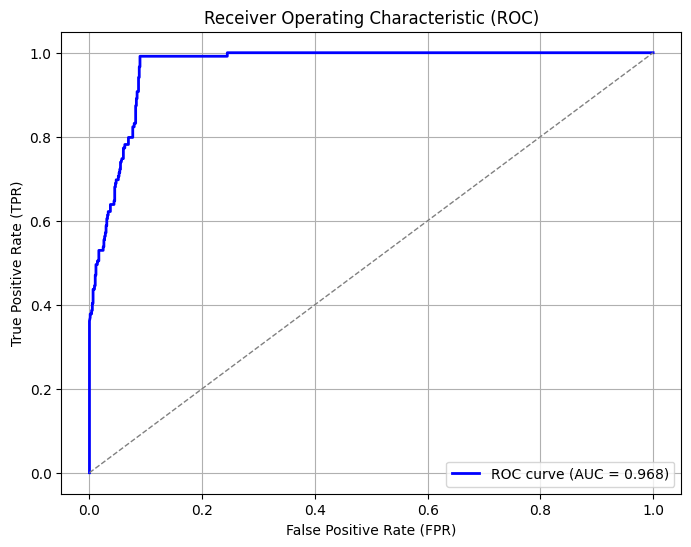

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
#save best model
import joblib

joblib.dump(best_model, os.path.join(GOOGLE_DRIVE_PATH, "final_best_model.pkl"))
print("Model saved as final_best_model.pkl")

Model saved as final_best_model.pkl


In [ ]:
clean_params_sorted = dict(sorted(clean_params.items()))

print("\nBest XGBoost Hyperparameters:\n")
for k, v in clean_params_sorted.items():
    print(f"• {k}: {v}")


Best XGBoost Hyperparameters:

• eval_metric: logloss
• learning_rate: 0.05
• max_depth: 3
• n_estimators: 100
• random_state: 42
• tree_method: hist
